This is to check the python script. For some reason, it was giving zero values everywhere.

In [ ]:
import numpy as np
import xarray as xr
import cf_xarray
import gsw as gsw
from xgcm import Grid
import gc
from tornado import gen
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

In [16]:
def select_subset(dataset):

    """Select subset of dataset in xr.open_mfdataset command
    """
    dataset = dataset.isel(i=slice(749,1199), j = slice(699, 1149)) # indices range
    dataset = dataset.drop(['vertices_latitude', 'vertices_longitude',
                            'time_bnds']) # drop variables

    return dataset

def compute_density(data_salinity, data_temperature):

    """Compute potential density using salinity and potential temperature data
    Parameters
    ----------
    data_salinity : xarray DataArray for salinity data
    data_temperature : xarray DataArray for potential temperature data

    Returns
    -------
    pot_density : xarray DataArray for potential density data
    """

    pot_density = gsw.density.sigma0(data_salinity, data_temperature)

    return pot_density

def density_levels(density_min=0., density_max=35.):

    """Define density levels
    Parameters
    ----------
    density_min : float value for minimum density
    density_max : float value for maximum density

    Returns
    -------
    sigma_levels : numpy array for density levels
    """

    density_rang1 = np.arange(density_min, 20., 2.0)
    density_rang2 = np.arange(20., 23.1, 1.)
    density_rang3 = np.arange(23.2, 26., 0.2)
    density_rang4 = np.arange(26.1, 28., 0.1)
    density_rang5 = np.arange(28.0, 28.8, 0.2)
    density_rang6 = np.arange(29.0, density_max, 1.)

    sigma_levels = np.concatenate((density_rang1 ,density_rang2, density_rang3, density_rang4,
                                   density_rang5, density_rang6))

    return sigma_levels

def transport_z(ds_vel, dz = 1., dx = 1., dim_v='Z', dim_x = 'X', assign_name='transport'):

    """Compute volume transport per unit horizontal length
    Parameters
    ----------
    ds_vel : xarray DataArray - velocity data
    dz : xarray DataArray - grid cell thickness
    dx : xarray DataArray - Zonal grid spacing
    dim_v : Vertical dimension name
    dim_x : Zonal dimension name
    assign_name : name for the volume transport

    Returns
    -------
    transport : xarray DataArray for volume transport
    """

    transport =  ds_vel * dz # velocity x vertical grid spacing
    transport = transport.fillna(0.).rename(assign_name)
    
    #vel_baro = ((ds_vel * dz * dx).sum(dim=[dim_v, dim_x])
    #            / (dz * dx).sum(dim=[dim_v, dim_x]))
        
    #transport_baro =  (vel_baro * dz).fillna(0.).rename(assign_name)

    return transport

def compute_barotropic(ds_vel, Field, grid, dim=None, dz = 1., dx = 1., dim_v='Z', dim_x = 'X'):
    
    """Compute zonal and depth mean velocity, and tracer field
    Parameters
    ----------
    ds_vel : xarray DataArray - velocity data
    Field : xarray DataArray/Datset - tracer field data
    grid : xgcm Grid object
    dim : dimension for interpolation to have tracel and velocity on the same grid
    dz : xarray DataArray - grid cell thickness
    dx : xarray DataArray - Zonal grid spacing
    dim_v : Vertical dimension name
    dim_x : Zonal dimension name

    Returns
    -------
    transport : xarray DataArray for volume transport
    """
    
    if(dim != None): # interpolate Field to velocity data grid
        
        Field_baro = xr.Dataset()
        for var in list(Field.keys()):
            Field_baro[var] = grid.interp(Field[var], [dim], boundary='extend')
    
    vel_baro = ((ds_vel * dz * dx).sum(dim=[dim_v, dim_x])
                / (dz * dx).sum(dim=[dim_v, dim_x]))
    
    Field_baro = ((Field_baro * dz * dx).sum(dim=[dim_v, dim_x])
                  / (dz * dx).sum(dim=[dim_v, dim_x]))
    
    return vel_baro, Field_baro

def transport_sigma(pot_density, transport, density_levels, grid, dim=None, method='linear'):

    """Compute volume transport in density layers using xgcm.transform method
    Parameters
    ----------
    pot_density : xarray DataArray - potential density
    transport : xarray DataArray - volume transport on z-levels
    density_levels : numpy array - Target density levels at which one wants to compute volume transport
    grid : xgcm Grid object
    dim : dimension for interpolation to have ensure pot_density and transport on the same grid
    method : transform method out of 'linear' or 'conservative'

    Returns
    -------
    transport_sigma : xarray DataArray - volume transport at denisty levels
    """

    if(dim != None): # interpolate the density to transport data grid
        sigma_interp = grid.interp(pot_density, [dim], boundary='extend')
    else:
        sigma_interp = pot_density

    sigma_interp = sigma_interp.rename('sigma0')
    transport_sigma = grid.transform(transport, 'Z', density_levels,
                                     target_data=sigma_interp, method=method, mask_edges = False)
    transport_sigma.sigma0.attrs['units'] = "kg/m^3"
    transport_sigma.sigma0.attrs['long_name'] = "Potential density with reference to ocean surface - 1000."

    return transport_sigma

def Compute_Tracer_transport(Field, Velocity, grid, dim, const_multi = 1.):

    """Compute transport of field along velocity component
    Parameters
    ----------
    Field : xarray DataArray - tracer field
    Velocity : xarray DataArray - velocity along any cartesian direction
    grid : xgcm Grid object
    dim : strig - dimension name
    const_multi : constant - multiplier

    Returns
    -------
    Transport : xarray DataArray for volume transport
    """

    Field_vel = grid.interp(Field, [dim], boundary='extend') # interpolate field to velocity grid

    Transport = Field_vel * Velocity * const_multi

    return Transport

def Compute_Overturning(Transport, dx = 1., dim_v='Z', dim_x = 'X', long_name=None):

    """Compute Overturning circulation using meridional velocity x thickness data
    Parameters
    ----------
    Transport : xarray DataArray - meridional velocity x layer thickness
    dx : xarray DataArray - Zonal grid spacing
    dz : xarray DataArray - Vertical cell thickness
    dim_v : Vertical dimension name
    dim_x : Zonal dimension name
    long_name : string - long name for the variable

    Returns
    -------
    overturning : xarray DataArray - overturning circulation
    overturning_barotropic : xarray DataArray - overturning circulation (barotropic component)
    """

    overturning = (Transport * dx).sum(dim=dim_x).cumsum(dim=dim_v)
    overturning.attrs['units'] = "m^3/s"
    overturning.attrs['long_name'] = long_name
    
    #dx_wet = dx * Transport / Transport
    #v_baro = ((Transport.sum(dim_v) * dx).sum(dim=dim_x) 
    #          / (dx_wet * dz).sum([dim_v, dim_x]))
    
    #overturning_barotropic = (v_baro * dz * dx_wet).sum(dim=dim_x).cumsum(dim=dim_v)
    #overturning_barotropic.attrs['units'] = "m^3/s"
    #overturning_barotropic.attrs['long_name'] = long_name + " – Barotropic"

    return overturning

def Meridional_Tracer_Transport_Overturning(Transport, Field, dx = 1., dz = 1., dim_x = 'X', dimen = None, long_name = None):

    """Compute Meriidonal Heat Transport corresponding to meridional overturning circulation
    Parameters
    ----------
    Transport : xarray DataArray - meridional velocity x layer thickness
    Field : xarray DataArray - Tracer Field x level thickness
    dx : xarray DataArray - Zonal grid spacing
    dz : xarray DataArray - Layer thicknesses
    dim_x : Zonal dimension name
    dimen : string - dimentional units for output
    long_name : string - long name for output

    Returns
    -------
    Meridional_Tracer_Transport : xarray DataArray - meridional tracer transport due to overturning circulation
    """

    Transport_Meridional = (Transport * dx).sum(dim=dim_x) # first get net meridional volume transport
    Meridional_Tracer = (Field * dx).sum(dim=dim_x) / ((dz * dx).sum(dim=dim_x) + 1.e-10) # zonal mean of tracer content
    # Field /Field is used in denominator, so only wet grid points are considered
    # + 1.e-10 is to avoid 0./0. situations

    Meridional_Tracer_Transport = Transport_Meridional * Meridional_Tracer

    Meridional_Tracer_Transport.attrs['units'] = dimen
    Meridional_Tracer_Transport.attrs['long_name'] = long_name

    return Meridional_Tracer_Transport

def save_data(data_var, save_location, short_name, long_name=None, var_units=None):
    """Save final diagnostics in netcdf format
    Parameters
    ----------
    data_var : xarray DataArray
    save_location : string - location for saving data including filename
    short_name : string - name for the variable
    long_name : string - long name for the variable
    var_units : string - dimensional units
    """
    
    data_save = data_var.astype(np.float32).to_dataset(name=short_name)
    data_save[short_name].attrs['units'] = var_units
    data_save[short_name].attrs['long_name'] = long_name
    
    data_save = data_save.compute() # compute before saving
    data_save.to_netcdf(save_location)
    
    print("Data saved succefully - ", short_name)
    
    data_save.close()
    
def get_latitude_masks(lat_val, yc, grid): # adopted from ecco_v4_py
    
    """Compute maskW/S which grabs vector field grid cells along specified latitude band 
    Parameters
    ----------
    lat_val : float - latitude at which to compute mask
    yc : xarray DataArray - Contains latitude values at cell centers
    grid : xgcm Grid object
    Returns
    -------
    maskWedge, maskSedge : xarray DataArray
        contains masks of latitude band at grid cell west and south grid edges
    """
    # Compute difference in X, Y direction.
    # multiply by 1 so that "True" -> 1, 2nd arg to "where" puts False -> 0
    ones = xr.ones_like(yc)
    maskC = ones.where(yc >= lat_val, 0)

    maskWedge = grid.diff(maskC, ['X'], boundary='fill')
    maskSedge = grid.diff(maskC, ['Y'], boundary='fill')

    return maskWedge, maskSedge

def meridional_overturning(ds_var, transport_u, transport_v, latitude, lat_vals, 
                           dx, dy, grid, mask_u, mask_v, dim='z'):
    
    """Compute meridional overturning at specified latitudes
    Parameters
    ----------
    ds_var : xarray Dataarray - To save overturning data
    transport_u : xarray DataArray - Zonal transport
    transport_v : xarray DataArray - Meridional transport
    latitude : xarray DataArray - latitude values at cell centers 
    lat_vals : Numpy array for range of lattiudes
    grid : xgcm Grid object
    dx : xarray DataArray - Zonal grid spacing at meridional velocity grid
    dy : xarray DataArray - Meridional grid spacing at zonal velocity grid
    mask_u : xarray Dataset - u mask for the Region of interest
    mask_v : xarray Dataset - v mask for the Region of interest
    dim : vertical dimension name
    Returns
    -------
    ds_var : xarray DataArray - meridional overturning at lat_vals
    """
    
    for lat in lat_vals:

        lat_maskW, lat_maskS = get_latitude_masks(lat, latitude, grid)
        

        lat_trsp_x = ((transport_u * lat_maskW * dy).where((mask_u == 0.))).sum(dim=['i_c','j'])
        lat_trsp_y = ((transport_v * lat_maskS * dx).where((mask_v == 0.))).sum(dim=['i','j_c'])
        
        ds_var.loc[{'lat':lat}] = lat_trsp_x + lat_trsp_y
        
    ds_var = ds_var.cumsum(dim=dim)
                    
    return ds_var

In [3]:
# first define paths for reading data and saving final diagnostics 
data_dir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"
save_path="/gws/nopw/j04/snapdragon/hkhatri/Data_sigma/Transport_sigma/Temp/"

# read grid information and masking data
ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")
ds_mask = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_UV_grid.nc")

year1, year2 = (2016, 2017) # range of years for reading data 
var_list = ['thetao', 'so', 'vo'] # list of variables to be read from model output

# get sigma levels
sigma_min, sigma_max = (15., 31.1) 
target_sigma_levels = density_levels(density_min=sigma_min, density_max=sigma_max)

rho_cp = 4.09 * 1.e6 # constant from Williams et al. 2015
S_ref = 35. # Reference salinity in psu

# Loop for going through multiple ensemble and hindcast members for computations
for r in range(0,1):
    
    for year in range(year1, year2, 1):
        
        print("Running: Ensemble = ", r+1, ", Hindcast Year = ", year)
        
        ds = []

        for var in var_list:

            var_path = (data_dir + "s" + str(year) +"-r" + str(r+1) + 
                        "i1p1f2/Omon/" + var + "/gn/latest/*.nc")

            with xr.open_mfdataset(var_path, parallel=True, preprocess=select_subset, 
                                   chunks={'time':1, 'j':45}, engine='netcdf4') as d:
                d = d 
            # chunksize is decided such a way that 
            # inter-worker communication is minimum and computations are efficient
                
            # renaming coords is required because variables are on different grid points (common in C-grid)
            # later xgcm.grid function is used to fix locations of these vars on model grid
            if(var == 'vo'):
                d = d.rename({'j':'j_c', 'longitude':'longitude_v', 'latitude':'latitude_v'})
            elif(var == 'uo'):
                d = d.rename({'i':'i_c', 'longitude':'longitude_u', 'latitude':'latitude_u'})

            ds.append(d)

        ds = xr.merge(ds) # merge to get a single dataset
        ds = xr.merge([ds, ds_grid['dx_v'].rename({'x':'i', 'yv':'j_c'}), 
                       ds_grid['dy_u'].rename({'xu':'i_c', 'y':'j'})]) 
        
        print("Data read complete")
        
        ds = ds.isel(time=slice(0,2)) # for checking only
        
        # ---------------------- Computations (points 1-3) ------------------------- #
        # create outer depth levels (required for transforming to density levels)
        level_outer_data = (cf_xarray.bounds_to_vertices(ds['lev_bnds'].isel(time=0),
                                                         'bnds').load().data)
        ds = ds.assign_coords({'level_outer': level_outer_data})
        
print(ds)

Running: Ensemble =  1 , Hindcast Year =  2016
Data read complete
<xarray.Dataset>
Dimensions:      (j: 450, i: 450, j_c: 450, time: 2, lev: 75, bnds: 2,
                  i_c: 450, level_outer: 76)
Coordinates:
  * j            (j) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) object 2016-11-16 00:00:00 2016-12-16 00:00:00
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude     (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude    (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    latitude_v   (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
  * level_outer  (level_outer) float64 0.0 1.024 2.103 ... 5.8e+03 6.004e+03


In [4]:
# create grid object such that xgcm is aware of locations of velocity and tracer grid points
grid = Grid(ds, coords={'Z': {'center': 'lev', 'outer': 'level_outer'},
                        'X': {'center': 'i', 'right': 'i_c'},
                        'Y': {'center': 'j', 'right': 'j_c'}}, periodic=[],)

dz = grid.diff(ds['level_outer'], 'Z')
cell_dz = xr.ones_like(ds['vo']) * dz *(ds['vo'].isel(time=0) / ds['vo'].isel(time=0))
#cell_dz = (cell_dz * ds['vo'] / ds['vo']).fillna(0.) # remove values for in-land grid cells

dx_v = ds['dx_v'].where(ds_mask['mask_North_Atl_v'] == 0.).compute() # dx mask for North Atlantic

# Compute barotropic velocity and tracer fields
[v_baro, tracer_baro] = compute_barotropic(ds['vo'], ds.get(['thetao', 'so']), grid, dim = 'Y', dz = cell_dz, dx = dx_v, dim_v='lev', dim_x = 'i')

# compute meridional volume and heat transport on z-levels
Meridional_Transport = transport_z(ds['vo'], dz = cell_dz, dx = dx_v, dim_v = 'lev', 
                                   dim_x = 'i', assign_name='Meridional_Transport')

Heat_Transport = Compute_Tracer_transport(ds['thetao'], Meridional_Transport, grid = grid,
                                          dim = 'Y', const_multi = rho_cp)

Salt_Transport = Compute_Tracer_transport(ds['so'], Meridional_Transport, grid = grid,
                                          dim = 'Y', const_multi = 1./S_ref)

print(Heat_Transport)

print(tracer_baro, v_baro, cell_dz)

<xarray.DataArray (time: 2, lev: 75, j_c: 450, i: 450)>
dask.array<mul, shape=(2, 75, 450, 450), dtype=float64, chunksize=(1, 75, 45, 450), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) object 2016-11-16 00:00:00 2016-12-16 00:00:00
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude_v   (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (j_c: 450, time: 2)
Coordinates:
  * j_c      (j_c) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * time     (time) object 2016-11-16 00:00:00 2016-12-16 00:00:00
Data variables:
    thetao   (time, j_c) float64 dask.array<chunksize=(1, 21), meta=np.ndarray>
    so       (time, j_c) float64 dask.array<chunk

In [5]:
# compute meridional volume and heat transport on sigma-levels
# conserve vertically integrated volume transport and heat transport
sigma = xr.apply_ufunc(compute_density, ds['so'], ds['thetao'], dask='parallelized',
                       output_dtypes=[ds['thetao'].dtype])
sigma = sigma.rename('sigma0') #.persist()

Meridional_Transport_sigma = transport_sigma(sigma, Meridional_Transport, target_sigma_levels,
                                             grid=grid, dim='Y',method='conservative')

Heat_Transport_sigma = transport_sigma(sigma, Heat_Transport, target_sigma_levels,
                                       grid=grid, dim='Y',method='conservative')

Salt_Transport_sigma = transport_sigma(sigma, Salt_Transport, target_sigma_levels,
                                       grid=grid, dim='Y',method='conservative')

Thickness_sigma = transport_sigma(sigma, cell_dz.fillna(0.), target_sigma_levels,
                                  grid=grid, dim='Y',method='conservative')

print(Heat_Transport_sigma)


<xarray.DataArray (time: 2, j_c: 450, i: 450, sigma0: 48)>
dask.array<transpose, shape=(2, 450, 450, 48), dtype=float64, chunksize=(1, 45, 450, 48), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) object 2016-11-16 00:00:00 2016-12-16 00:00:00
    latitude_v   (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
  * sigma0       (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.7 28.9 29.5 30.5


<xarray.DataArray 'sigma0' (sigma0: 48)>
array([16.  , 18.  , 19.5 , 20.5 , 21.5 , 22.5 , 23.1 , 23.3 , 23.5 , 23.7 ,
       23.9 , 24.1 , 24.3 , 24.5 , 24.7 , 24.9 , 25.1 , 25.3 , 25.5 , 25.7 ,
       25.9 , 26.05, 26.15, 26.25, 26.35, 26.45, 26.55, 26.65, 26.75, 26.85,
       26.95, 27.05, 27.15, 27.25, 27.35, 27.45, 27.55, 27.65, 27.75, 27.85,
       27.95, 28.1 , 28.3 , 28.5 , 28.7 , 28.9 , 29.5 , 30.5 ])
Coordinates:
  * sigma0   (sigma0) float64 16.0 18.0 19.5 20.5 21.5 ... 28.7 28.9 29.5 30.5
Attributes:
    units:      kg/m^3
    long_name:  Potential density with reference to ocean surface - 1000.


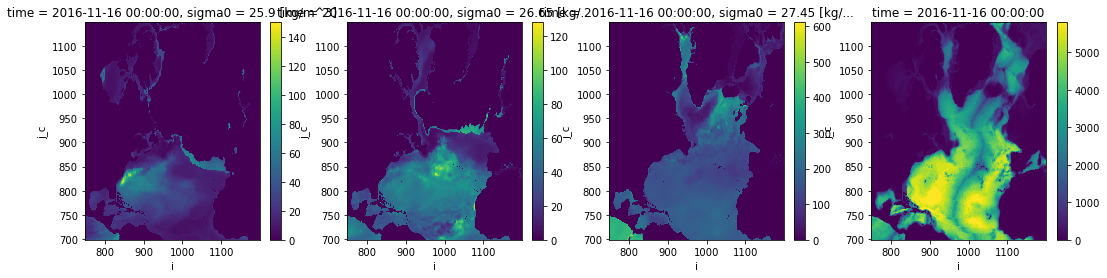

In [19]:
print(Thickness_sigma.sigma0)

fig = plt.figure(figsize=[18,4])

plt.subplot(1,4,1)
(Thickness_sigma.isel(time=0, sigma0=20)).plot()

plt.subplot(1,4,2)
(Thickness_sigma.isel(time=0, sigma0=27)).plot()

plt.subplot(1,4,3)
(Thickness_sigma.isel(time=0, sigma0=35)).plot()

plt.subplot(1,4,4)
(Thickness_sigma.isel(time=0).sum('sigma0')).plot()

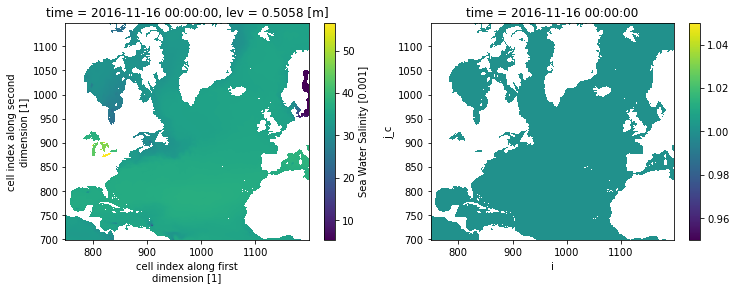

In [21]:
# Compare the nan values for landmass
# We recover the same area, so conservative method on dz works well.

tmp = Thickness_sigma.isel(time=0).sum('sigma0') / Thickness_sigma.isel(time=0).sum('sigma0')

fig = plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
ds['so'].isel(time=0,lev=0).plot()

plt.subplot(1,2,2)
tmp.plot()

### Overturning computations

Here, we check the computations of overturning circulation.
1. Baroclinic component of overturning – net meridional volume transport is zero
2. Barotropic component 

In [6]:
# Overturning computations

ds_save = xr.Dataset()

ds_save['latitude'] = ds['latitude_v'].where(ds_mask['mask_North_Atl_v']).mean('i').compute()

with xr.set_options(keep_attrs=True):
    ds_save['Overturning_z'] = Compute_Overturning(Meridional_Transport, dx = dx_v, dim_v = 'lev',
                                                   dim_x = 'i', long_name="Overturning circulation vs depth")
            
    Meridional_Transport_baro = cell_dz * v_baro
    ds_save['Overturning_z_barotropic'] = Compute_Overturning(Meridional_Transport_baro, dx = dx_v, dim_v = 'lev', dim_x = 'i', 
                                                              long_name="Overturning circulation vs depth - Barotropic Component")

In [7]:
ds_save = ds_save.transpose('time','lev','j_c')
print(ds_save)

<xarray.Dataset>
Dimensions:                   (j_c: 450, time: 2, lev: 75)
Coordinates:
  * j_c                       (j_c) int64 699 700 701 702 ... 1146 1147 1148
  * time                      (time) object 2016-11-16 00:00:00 2016-12-16 00...
  * lev                       (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
Data variables:
    latitude                  (j_c) float32 4.121 4.371 4.62 ... 75.82 75.9
    Overturning_z             (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_z_barotropic  (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>


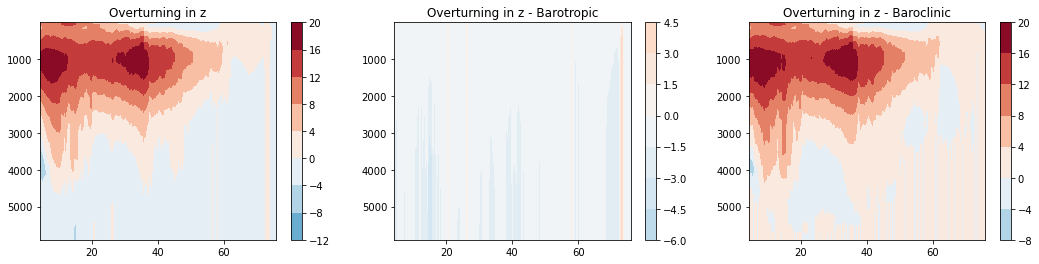

In [14]:
fig = plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['Overturning_z'].mean('time')/1e6, 
            vmin=-20., vmax=20., cmap='RdBu_r')
plt.colorbar()
plt.title('Overturning in z')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['Overturning_z_barotropic'].mean('time')/1e6, 
             vmin=-20., vmax=20., cmap='RdBu_r')
plt.colorbar()
plt.title('Overturning in z - Barotropic')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.contourf(ds_save['latitude'], ds_save['lev'], (ds_save['Overturning_z'] - ds_save['Overturning_z_barotropic']).mean('time')/1e6, 
             vmin=-20., vmax=20., cmap='RdBu_r')
plt.colorbar()
plt.title('Overturning in z - Baroclinic')
plt.gca().invert_yaxis()

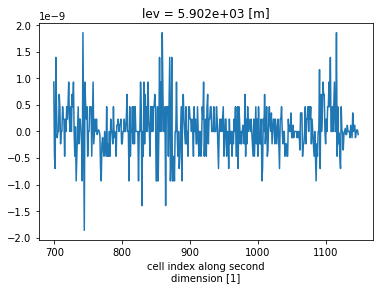

In [25]:
(ds_save['Overturning_z'] - ds_save['Overturning_z_barotropic']).isel(lev=-1,time=0).drop('time').plot()

In [8]:
Overturning_sigma = Compute_Overturning(Meridional_Transport_sigma, dx = dx_v, dim_v = 'sigma0', dim_x = 'i', 
                                        long_name="Overturning circulation vs sigma0")

Meridional_Transport_sigma_baro = Thickness_sigma * v_baro
Overturning_sigma_barotropic = Compute_Overturning(Meridional_Transport_sigma_baro, dx = dx_v, dim_v = 'sigma0', dim_x = 'i', 
                                                   long_name="Overturning circulation vs sigma0 - Barotropic Component")
    
with xr.set_options(keep_attrs=True):
    ds_save['Overturning_sigma'] = Overturning_sigma
    ds_save['Overturning_sigma_barotropic'] = Overturning_sigma_barotropic
    
ds_save = ds_save.transpose('time','sigma0', 'lev','j_c')
print(ds_save)

<xarray.Dataset>
Dimensions:                       (j_c: 450, time: 2, lev: 75, sigma0: 48)
Coordinates:
  * j_c                           (j_c) int64 699 700 701 702 ... 1146 1147 1148
  * time                          (time) object 2016-11-16 00:00:00 2016-12-1...
  * lev                           (lev) float64 0.5058 1.556 ... 5.902e+03
  * sigma0                        (sigma0) float64 16.0 18.0 19.5 ... 29.5 30.5
Data variables:
    latitude                      (j_c) float32 4.121 4.371 4.62 ... 75.82 75.9
    Overturning_z                 (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_z_barotropic      (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_sigma             (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    Overturning_sigma_barotropic  (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>


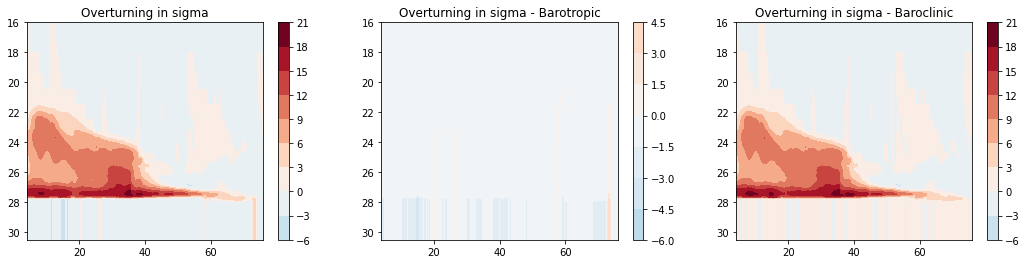

In [29]:
fig = plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['Overturning_sigma'].mean('time')/1e6, 
            vmin=-20., vmax=20., cmap='RdBu_r')
plt.colorbar()
plt.title('Overturning in sigma')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['Overturning_sigma_barotropic'].mean('time')/1e6, 
             vmin=-20., vmax=20., cmap='RdBu_r')
plt.colorbar()
plt.title('Overturning in sigma - Barotropic')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], (ds_save['Overturning_sigma'] - ds_save['Overturning_sigma_barotropic']).mean('time')/1e6, 
             vmin=-20., vmax=20., cmap='RdBu_r')
plt.colorbar()
plt.title('Overturning in sigma - Baroclinic')
plt.gca().invert_yaxis()

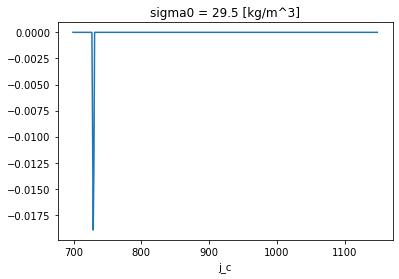

In [33]:
((ds_save['Overturning_sigma'] - ds_save['Overturning_sigma_barotropic']) / 1e6).isel(sigma0=-2).mean('time').plot()

### Heat Transport

Here, we check northward heat transport calculations. There are five terms.
1. zonal-depth mean v and zonal-depth mean theta  - Barotropic component
2. zonal-depth mean v and zonal-mean theta (zero depth-mean) - Overturning
3. zonal-mean v (zero depth-mean) and zonal-depth mean theta - Overturning
4. zonal-mean v (zero depth-mean) and zonal-mean theta (zero depth-mean) - Overturning
5. Horizontal variations in v and theta - Horizontal circulation

In [9]:
(target_sigma_levels[1:] + target_sigma_levels[:-1])*0.5

array([16.  , 18.  , 19.5 , 20.5 , 21.5 , 22.5 , 23.1 , 23.3 , 23.5 ,
       23.7 , 23.9 , 24.1 , 24.3 , 24.5 , 24.7 , 24.9 , 25.1 , 25.3 ,
       25.5 , 25.7 , 25.9 , 26.05, 26.15, 26.25, 26.35, 26.45, 26.55,
       26.65, 26.75, 26.85, 26.95, 27.05, 27.15, 27.25, 27.35, 27.45,
       27.55, 27.65, 27.75, 27.85, 27.95, 28.1 , 28.3 , 28.5 , 28.7 ,
       28.9 , 29.5 , 30.5 ])

In [11]:
thetao_vel = grid.interp(ds['thetao'], 'Y', boundary='extend') # interpolate to velocity grid

dz = grid.diff(ds['level_outer'], 'Z')

thetao_sigma = transport_sigma(sigma, (thetao_vel * dz).fillna(0.), target_sigma_levels,
                               grid=grid, dim='Y', method='conservative') # for overturning heat transport

#thetao_sigma = thetao_sigma.drop('sigma0')
#thetao_sigma = 0.5 * (thetao_sigma.isel(sigma0=slice(0,-1)) +
#                      thetao_sigma.isel(sigma0=slice(1,len(thetao_sigma.sigma0)))) # to get T at correct sigma0 levels
#thetao_sigma = grid.interp(thetao_sigma, 'Y', boundary='extend')

so_vel = grid.interp(ds['thetao'], 'Y', boundary='extend') # interpolate to velocity grid

so_sigma = transport_sigma(sigma, (so_vel * dz).fillna(0.), target_sigma_levels,
                           grid=grid, dim='Y',method='conservative') # for overturning FW transport
#so_sigma = so_sigma.drop('sigma0')
#so_sigma = 0.5 * (so_sigma.isel(sigma0=slice(0,-1)) + 
#                  so_sigma.isel(sigma0=slice(1,len(so_sigma.sigma0)))) # to get so at correct sigma0 levels
#so_sigma = grid.interp(so_sigma, 'Y', boundary='extend')

In [12]:
print(thetao_sigma)

<xarray.DataArray (time: 2, j_c: 450, i: 450, sigma0: 48)>
dask.array<transpose, shape=(2, 450, 450, 48), dtype=float64, chunksize=(1, 45, 450, 48), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 749 750 751 752 753 754 ... 1193 1194 1195 1196 1197 1198
  * j_c      (j_c) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * time     (time) object 2016-11-16 00:00:00 2016-12-16 00:00:00
  * sigma0   (sigma0) float64 16.0 18.0 19.5 20.5 21.5 ... 28.7 28.9 29.5 30.5


In [17]:
# Heat transport in sigma-space

ds_save['MHT_sigma'] = (Heat_Transport_sigma * dx_v).sum(dim='i')
ds_save['MHT_sigma'].attrs['units'] = "Joules/s"
ds_save['MHT_sigma'].attrs['long_name'] = "Meridional heat transport"

ds_save['MHT_sigma_baro'] = (Thickness_sigma * v_baro * tracer_baro['thetao'] * rho_cp * dx_v).sum(dim='i')
ds_save['MHT_sigma_baro'].attrs['units'] = "Joules/s"
ds_save['MHT_sigma_baro'].attrs['long_name'] = "Meridional heat transport - Barotropic v and Barotropic theta"

heat_content_sigma = (thetao_sigma - tracer_baro['thetao'] * Thickness_sigma) * rho_cp
transport = Meridional_Transport_sigma - Thickness_sigma * v_baro
ds_save['MHT_overturning_sigma'] = Meridional_Tracer_Transport_Overturning(transport, heat_content_sigma,
                                                                           dx = dx_v, dz = Thickness_sigma, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional heat transport due to overturning circulation - Baroclinic v and Baroclinic theta")

heat_content_sigma = (thetao_sigma - tracer_baro['thetao'] * Thickness_sigma) * rho_cp
transport = Thickness_sigma * v_baro
ds_save['MHT_overturning_sigma_baro_v'] = Meridional_Tracer_Transport_Overturning(transport, heat_content_sigma,
                                                                           dx = dx_v, dz = Thickness_sigma, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional heat transport due to overturning circulation - Barotropic v and Baroclinic theta")

heat_content_sigma = tracer_baro['thetao'] * Thickness_sigma * rho_cp
transport = Meridional_Transport_sigma - Thickness_sigma * v_baro
ds_save['MHT_overturning_sigma_baro_theta'] = Meridional_Tracer_Transport_Overturning(transport, heat_content_sigma,
                                                                           dx = dx_v, dz = Thickness_sigma, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional heat transport due to overturning circulation - Baroclinic v and Barotropic theta")

ds_save = ds_save.transpose('time','sigma0', 'lev','j_c')
print(ds_save)

<xarray.Dataset>
Dimensions:                           (j_c: 450, time: 2, lev: 75, sigma0: 48)
Coordinates:
  * j_c                               (j_c) int64 699 700 701 ... 1146 1147 1148
  * time                              (time) object 2016-11-16 00:00:00 2016-...
  * lev                               (lev) float64 0.5058 1.556 ... 5.902e+03
  * sigma0                            (sigma0) float64 16.0 18.0 ... 29.5 30.5
Data variables: (12/15)
    latitude                          (j_c) float32 4.121 4.371 ... 75.82 75.9
    Overturning_z                     (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_z_barotropic          (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_sigma                 (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    Overturning_sigma_barotropic      (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    MH

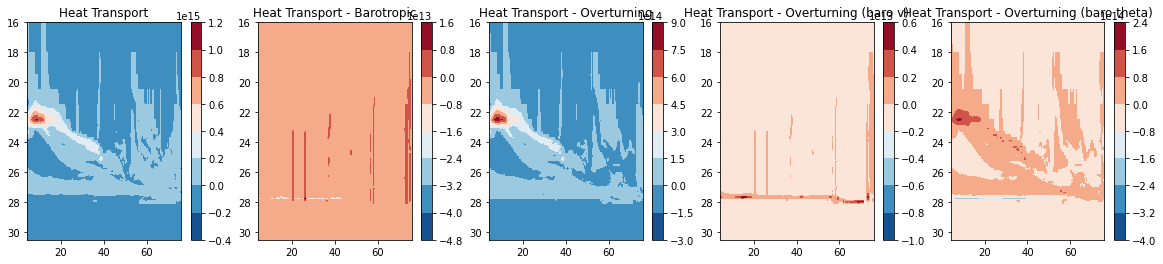

In [57]:
fig = plt.figure(figsize=[20,4])

plt.subplot(1,5,1)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['MHT_sigma'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport')
plt.gca().invert_yaxis()

plt.subplot(1,5,2)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['MHT_sigma_baro'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Barotropic')
plt.gca().invert_yaxis()

plt.subplot(1,5,3)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['MHT_overturning_sigma'].fillna(0.).mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Overturning')
plt.gca().invert_yaxis()

plt.subplot(1,5,4)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['MHT_overturning_sigma_baro_v'].fillna(0.).mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Overturning (baro v)')
plt.gca().invert_yaxis()

plt.subplot(1,5,5)
plt.contourf(ds_save['latitude'], ds_save['sigma0'], ds_save['MHT_overturning_sigma_baro_theta'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Overturning (baro theta)')
plt.gca().invert_yaxis()


In [14]:
# Heat tranport in depth-space

ds_save['MHT_z'] = (Heat_Transport * dx_v).sum(dim='i')
ds_save['MHT_z'].attrs['units'] = "Joules/s"
ds_save['MHT_z'].attrs['long_name'] = "Meridional heat transport"

ds_save['MHT_z_baro'] = (cell_dz * v_baro * tracer_baro['thetao'] * rho_cp * dx_v).sum(dim='i')
ds_save['MHT_z_baro'].attrs['units'] = "Joules/s"
ds_save['MHT_z_baro'].attrs['long_name'] = "Meridional heat transport - Barotropic v and Barotropic theta"

heat_content_z = (thetao_vel - tracer_baro['thetao']) * cell_dz * rho_cp
transport = Meridional_Transport - cell_dz * v_baro
ds_save['MHT_overturning_z'] = Meridional_Tracer_Transport_Overturning(transport, heat_content_z,
                                                                           dx = dx_v, dz = cell_dz, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional heat transport due to overturning circulation - Baroclinic v and Baroclinic theta")

heat_content_z = (thetao_vel - tracer_baro['thetao']) * cell_dz * rho_cp
transport = cell_dz * v_baro
ds_save['MHT_overturning_z_baro_v'] = Meridional_Tracer_Transport_Overturning(transport, heat_content_z,
                                                                           dx = dx_v, dz = cell_dz, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional heat transport due to overturning circulation - Barotropic v and Baroclinic theta")

heat_content_z = tracer_baro['thetao'] * cell_dz * rho_cp
transport = Meridional_Transport - cell_dz * v_baro
ds_save['MHT_overturning_z_baro_theta'] = Meridional_Tracer_Transport_Overturning(transport, heat_content_z,
                                                                           dx = dx_v, dz = cell_dz, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional heat transport due to overturning circulation - Baroclinic v and Barotropic theta")

ds_save = ds_save.transpose('time','sigma0', 'lev','j_c')
print(ds_save)

<xarray.Dataset>
Dimensions:                           (j_c: 450, time: 2, lev: 75, sigma0: 48)
Coordinates:
  * j_c                               (j_c) int64 699 700 701 ... 1146 1147 1148
  * time                              (time) object 2016-11-16 00:00:00 2016-...
  * lev                               (lev) float64 0.5058 1.556 ... 5.902e+03
  * sigma0                            (sigma0) float64 16.0 18.0 ... 29.5 30.5
Data variables: (12/15)
    latitude                          (j_c) float32 4.121 4.371 ... 75.82 75.9
    Overturning_z                     (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_z_barotropic          (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_sigma                 (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    Overturning_sigma_barotropic      (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    MH

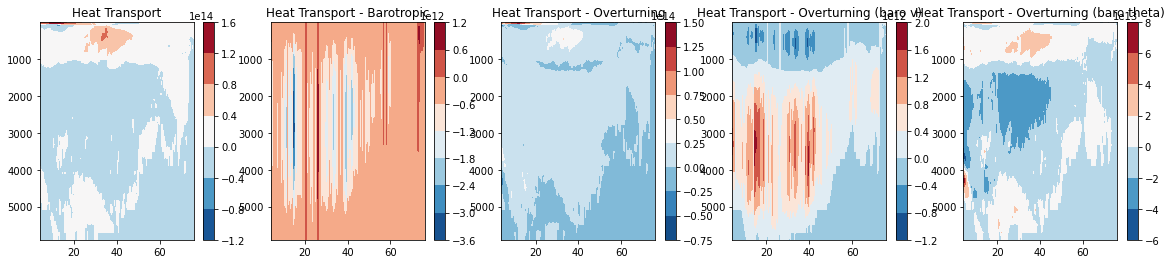

In [15]:
fig = plt.figure(figsize=[20,4])

plt.subplot(1,5,1)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MHT_z'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport')
plt.gca().invert_yaxis()

plt.subplot(1,5,2)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MHT_z_baro'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Barotropic')
plt.gca().invert_yaxis()

plt.subplot(1,5,3)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MHT_overturning_z'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Overturning')
plt.gca().invert_yaxis()

plt.subplot(1,5,4)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MHT_overturning_z_baro_v'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Overturning (baro v)')
plt.gca().invert_yaxis()

plt.subplot(1,5,5)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MHT_overturning_z_baro_theta'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Heat Transport - Overturning (baro theta)')
plt.gca().invert_yaxis()

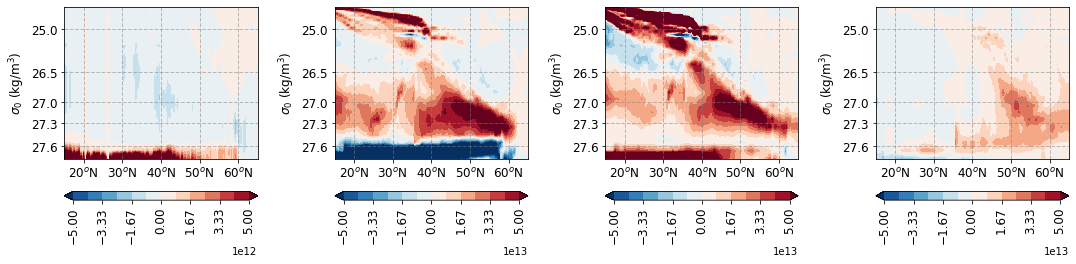

In [18]:
grid1 = plt.GridSpec(1, 4, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[18,4])

lat = ds_save['latitude']

tmp = ds_save['MHT_overturning_sigma_baro_v'].mean('time').isel(j_c=slice(0,340))
tmp = tmp.fillna(0.).assign_coords(j_c=lat.isel(j_c=slice(0,340)))
rng_nl = ds_save['sigma0']* np.arange(0, len(ds_save['sigma0']))**2
tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
        
ax = fig.add_subplot(grid1[0,0])
p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 13, vmin = -0.5e13, vmax = 0.5e13,
                        cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
cb = fig.colorbar(p, ax=ax, orientation="horizontal")
cb.ax.tick_params(labelsize=12,  rotation =90)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
ax.set_xlim([15., 65.])
ax.set_ylim([0., 40000.])
plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

tmp = ds_save['MHT_overturning_sigma_baro_theta'].mean('time').isel(j_c=slice(0,340))
tmp = tmp.fillna(0.).assign_coords(j_c=lat.isel(j_c=slice(0,340)))
rng_nl = ds_save['sigma0']* np.arange(0, len(ds_save['sigma0']))**2
tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
        
ax = fig.add_subplot(grid1[0,1])
p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 13, vmin = -5e13, vmax = 5e13,
                        cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
cb = fig.colorbar(p, ax=ax, orientation="horizontal")
cb.ax.tick_params(labelsize=12,  rotation =90)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
ax.set_xlim([15., 65.])
ax.set_ylim([0., 40000.])
plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

tmp = ds_save['MHT_overturning_sigma'].mean('time').isel(j_c=slice(0,340))
tmp = tmp.fillna(0.).assign_coords(j_c=lat.isel(j_c=slice(0,340)))
rng_nl = ds_save['sigma0']* np.arange(0, len(ds_save['sigma0']))**2
tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
        
ax = fig.add_subplot(grid1[0,2])
p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 13, vmin = -5e13, vmax = 5e13,
                        cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
cb = fig.colorbar(p, ax=ax, orientation="horizontal")
cb.ax.tick_params(labelsize=12,  rotation =90)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
ax.set_xlim([15., 65.])
ax.set_ylim([0., 40000.])
plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

tmp = ( ds_save['MHT_sigma'] - ds_save['MHT_overturning_sigma'] - ds_save['MHT_overturning_sigma_baro_theta'] - 
      ds_save['MHT_overturning_sigma_baro_v'] - ds_save['MHT_sigma_baro']).mean('time').isel(j_c=slice(0,340))
tmp = tmp.fillna(0.).assign_coords(j_c=lat.isel(j_c=slice(0,340)))
rng_nl = ds_save['sigma0']* np.arange(0, len(ds_save['sigma0']))**2
tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
        
ax = fig.add_subplot(grid1[0,3])
p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 13, vmin = -5e13, vmax = 5e13,
                        cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
cb = fig.colorbar(p, ax=ax, orientation="horizontal")
cb.ax.tick_params(labelsize=12,  rotation =90)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
ax.set_xlim([15., 65.])
ax.set_ylim([0., 40000.])
plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

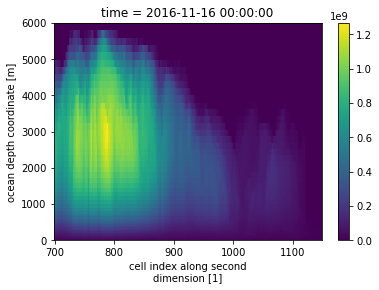

In [32]:
(cell_dz.fillna(0.) * dx_v).sum('i').isel(time=0).plot()

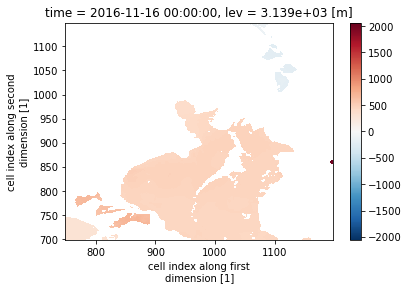

In [29]:
(thetao_vel * dz).isel(time=0, lev=60).plot()

### Salt/Freshwater Transport

Here, we check northward salt transport calculations. There are five terms.
1. zonal-depth mean v and zonal-depth mean salt  - Barotropic component
2. zonal-depth mean v and zonal-mean salt (zero depth-mean) - Overturning
3. zonal-mean v (zero depth-mean) and zonal-depth mean salt - Overturning
4. zonal-mean v (zero depth-mean) and zonal-mean salt (zero depth-mean) - Overturning
5. Horizontal variations in v and salt - Horizontal circulation

In [39]:
# Heat tranport in depth-space

ds_save['MFT_z'] = -(Salt_Transport * dx_v).sum(dim='i')
ds_save['MFT_z'].attrs['units'] = "m^3/s"
ds_save['MFT_z'].attrs['long_name'] = "Meridional freshwater transport"

ds_save['MFT_z_baro'] = - (cell_dz * v_baro * tracer_baro['so'] * dx_v / S_ref).sum(dim='i')
ds_save['MFT_z_baro'].attrs['units'] = "Joules/s"
ds_save['MFT_z_baro'].attrs['long_name'] = "Meridional freshwater transport - Barotropic v and Barotropic salt"

so_vel = grid.interp(ds['so'], 'Y', boundary='extend') # interpolate to velocity grid
salt_content_z =  - (so_vel - tracer_baro['so']) / S_ref
transport = Meridional_Transport - cell_dz * v_baro
ds_save['MFT_overturning_z'] = Meridional_Tracer_Transport_Overturning(transport, salt_content_z,
                                                                           dx = dx_v, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional freshwater transport due to overturning circulation - Baroclinic v and Baroclinic theta")

salt_content_z =  - (so_vel - tracer_baro['so']) / S_ref
transport = cell_dz * v_baro
ds_save['MFT_overturning_z_baro_v'] = Meridional_Tracer_Transport_Overturning(transport, salt_content_z,
                                                                           dx = dx_v, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional freshwater transport due to overturning circulation - Barotropic v and Baroclinic theta")

salt_content_z =  - tracer_baro['so'] / S_ref
transport = Meridional_Transport - cell_dz * v_baro
ds_save['MFT_overturning_z_baro_theta'] = Meridional_Tracer_Transport_Overturning(transport, salt_content_z,
                                                                           dx = dx_v, dim_x = 'i', dimen = "Joules/s",
                                                                           long_name = "Meridional freshwater transport due to overturning circulation - Baroclinic v and Barotropic theta")

ds_save = ds_save.transpose('time','sigma0', 'lev','j_c')
print(ds_save)

<xarray.Dataset>
Dimensions:                           (j_c: 450, time: 2, lev: 75, sigma0: 48)
Coordinates:
  * j_c                               (j_c) int64 699 700 701 ... 1146 1147 1148
  * time                              (time) object 2016-11-16 00:00:00 2016-...
  * lev                               (lev) float64 0.5058 1.556 ... 5.902e+03
  * sigma0                            (sigma0) float64 16.0 18.0 ... 29.5 30.5
Data variables: (12/20)
    latitude                          (j_c) float32 4.121 4.371 ... 75.82 75.9
    Overturning_z                     (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_z_barotropic          (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 21), meta=np.ndarray>
    Overturning_sigma                 (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    Overturning_sigma_barotropic      (time, sigma0, j_c) float64 dask.array<chunksize=(1, 48, 21), meta=np.ndarray>
    MH

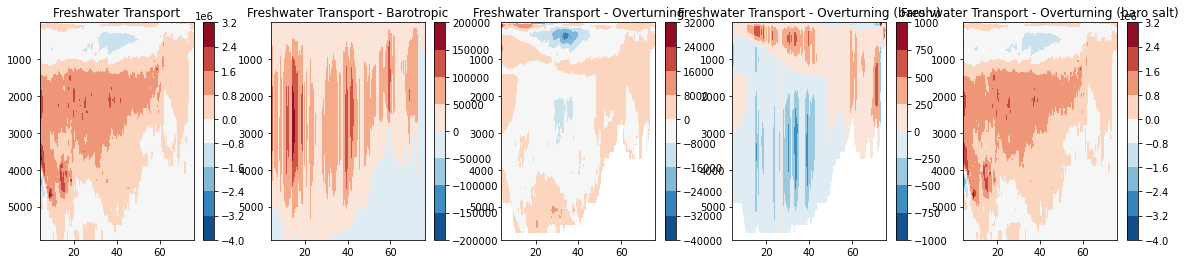

In [56]:
fig = plt.figure(figsize=[20,4])

plt.subplot(1,5,1)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MFT_z'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Freshwater Transport')
plt.gca().invert_yaxis()

plt.subplot(1,5,2)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MFT_z_baro'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Freshwater Transport - Barotropic')
plt.gca().invert_yaxis()

plt.subplot(1,5,3)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MFT_overturning_z'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Freshwater Transport - Overturning')
plt.gca().invert_yaxis()

plt.subplot(1,5,4)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MFT_overturning_z_baro_v'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Freshwater Transport - Overturning (baro v)')
plt.gca().invert_yaxis()

plt.subplot(1,5,5)
plt.contourf(ds_save['latitude'], ds_save['lev'], ds_save['MFT_overturning_z_baro_theta'].mean('time'), cmap='RdBu_r')
plt.colorbar()
plt.title('Freshwater Transport - Overturning (baro salt)')
plt.gca().invert_yaxis()

### Different overturning calulation algorithm

The algorithm below uses both meridional and zonal volume transport to compute overturning circulation. The code is taken from a python package for calculating diasgnotics in MITgcm model. The algorithm works fine; however, it is much slower than just integrating along 'i'. The results are not significantly different, so one use either of the algorithms. 

In [75]:
%%time

# -------------------- Computating Overturning (point 4) ------------------------- #
ds_save = xr.Dataset() # creating dataset for saving results
        
# first create xarray dataarray for overturning vars
lat_range = np.arange(2., 70., 5.) # lat values at which overturning is computed
        
tmp_array_sigma = np.empty((len(ds['time']), len(Meridional_Transport_sigma['sigma0']), len(lat_range)))
tmp_array_z = np.empty((len(ds['time']), len(Meridional_Transport['lev']), len(lat_range)))
        
ds_save['Overturning_sigma'] = xr.DataArray(data=tmp_array_sigma.copy(), 
                                            coords={'time':ds['time'], 
                                                    'sigma0': Zonal_Transport_sigma['sigma0'],
                                                    'lat': lat_range},
                                            dims=['time', 'sigma0','lat'])
        
ds_save['Overturning_z'] = xr.DataArray(data=tmp_array_z.copy(), coords={'time':ds['time'],
                                                                         'lev': Zonal_Transport['lev'],
                                                                        'lat': lat_range},
                                        dims=['time', 'lev','lat'])

        
ds_save['Overturning_sigma'] = meridional_overturning(ds_save['Overturning_sigma'], 
                                                      Zonal_Transport_sigma, Meridional_Transport_sigma, ds['latitude'], lat_range,
                                                      ds['dx_v'], ds['dy_u'], grid, ds_mask['mask_North_Atl_u'],
                                                      ds_mask['mask_North_Atl_v'], dim='sigma0')
        
ds_save['Overturning_z'] = meridional_overturning(ds_save['Overturning_z'], Zonal_Transport,
                                                  Meridional_Transport, ds['latitude'], lat_range,
                                                  ds['dx_v'], ds['dy_u'], grid, ds_mask['mask_North_Atl_u'],
                                                  ds_mask['mask_North_Atl_v'], dim='lev')
ds_save['Overturning_z'] = ds_save['Overturning_z'] - ds_save['Overturning_z'].isel(lev=-1) # to integrate from top to bottom

CPU times: user 1min 27s, sys: 15.6 s, total: 1min 43s
Wall time: 1min 7s


In [76]:
print(ds_save)

%time ds_save = ds_save.compute()

<xarray.Dataset>
Dimensions:            (time: 2, sigma0: 58, lat: 14, lev: 75)
Coordinates:
  * time               (time) object 2016-11-16 00:00:00 2016-12-16 00:00:00
  * sigma0             (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.75 29.5 30.5
  * lat                (lat) float64 2.0 7.0 12.0 17.0 ... 52.0 57.0 62.0 67.0
  * lev                (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Data variables:
    Overturning_sigma  (time, sigma0, lat) float64 0.0 0.0 ... -1.508e+06
    Overturning_z      (time, lev, lat) float64 7.331e+05 3.024e+06 ... 0.0 0.0
CPU times: user 0 ns, sys: 481 µs, total: 481 µs
Wall time: 431 µs


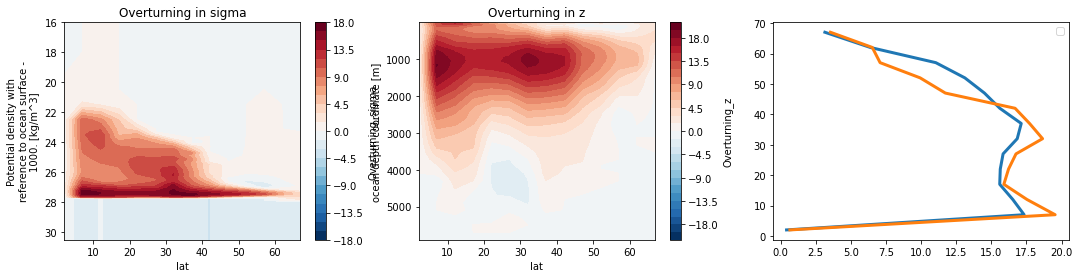

In [66]:
# with 26., 26.2, ..... 27.8, 27.9 density levels
fig = plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
(ds_save['Overturning_sigma'].mean('time')/1e6).plot.contourf(x='lat', levels=31)
plt.title('Overturning in sigma')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
(ds_save['Overturning_z'].mean('time')/1e6).plot.contourf(x='lat', levels=31)
plt.title('Overturning in z')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.plot(ds_save['Overturning_sigma'].max('sigma0').mean('time')/1e6, ds_save.lat, ls='-', lw=3) 
plt.plot(ds_save['Overturning_z'].max('lev').mean('time')/1e6, ds_save.lat, ls='-', lw=3) 
plt.legend('sigma', 'z')

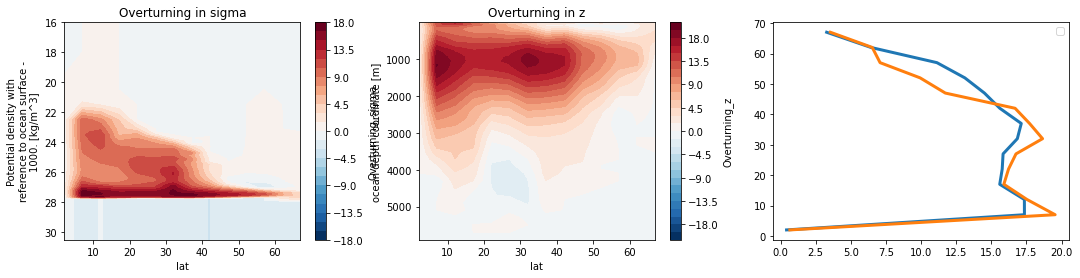

In [77]:
# with 26.5, 26.55, ..... 27.85, 27.9 density levels
fig = plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
(ds_save['Overturning_sigma'].mean('time')/1e6).plot.contourf(x='lat', levels=31)
plt.title('Overturning in sigma')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
(ds_save['Overturning_z'].mean('time')/1e6).plot.contourf(x='lat', levels=31)
plt.title('Overturning in z')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.plot(ds_save['Overturning_sigma'].max('sigma0').mean('time')/1e6, ds_save.lat, ls='-', lw=3) 
plt.plot(ds_save['Overturning_z'].max('lev').mean('time')/1e6, ds_save.lat, ls='-', lw=3) 
plt.legend('sigma', 'z')

In [70]:
target_sigma_levels = density_levels(density_min=sigma_min, density_max=sigma_max)
print(target_sigma_levels)
print(target_sigma_levels.shape)

[15.   17.   19.   20.   21.   22.   23.   23.2  23.4  23.6  23.8  24.
 24.2  24.4  24.6  24.8  25.   25.2  25.4  25.6  25.8  26.   26.2  26.4
 26.5  26.55 26.6  26.65 26.7  26.75 26.8  26.85 26.9  26.95 27.   27.05
 27.1  27.15 27.2  27.25 27.3  27.35 27.4  27.45 27.5  27.55 27.6  27.65
 27.7  27.75 27.8  27.85 27.9  27.95 28.   28.5  29.   30.   31.  ]
(59,)
